# Image slicer spot simulation (v03)
*A. Bolton, 2024 Jan/Feb*

*This notebook implements an initial model for an image slicer of a particular type. Just one slice right now, plus the various intermediate planes after it. Can tip/tilt PSF around to create more complex simulations.*

*This "lossplots" variation is for checking the diffraction losses at various apertures and wavelengths.*

Release notes for v03:
 - Code is somewhat more sensible now
   - specification of parameters and geometries has been made more systematic
 - Orientation of x and y swapped relative to v02 to match the x/y convention in Tim's ppt
   - *tips* are now *tilts*; apologies for any downstream inconvenience!
 - Added support for different samplings (fine, coarse, very coarse)
 - Added support for anamorphism EXCEPT for at-detector sampling
   - *detector sampling is correct in the spectral direction but would need to be rescaled in the direction along the slit*
   - input beam anamorphism not included in oct23 models
   - input beam anamorphism yes included in feb24 models
   - spectrograph limiting aperture is currently only implemented as rectangle. Will need to implement elliptical apertures to model circle+anamorph.

In [1]:
# Imports:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import poppy
from poppy.poppy_core import PlaneType
import astropy.units as u
import astropy.io.fits as fits
import skimage.measure
import pandas as pd
from copy import deepcopy

In [2]:
# Parameters for O-2/oct23, fine:
par_dict_fine = {
    'diam': 6.5*u.m,
    'sec_rad': 0.65*u.m,
    'n_supp': 3,
    'supp_wid': 0.15*u.m,
    'input_fratio_x': 159.,
    'input_fratio_y': 159.,
    'slicer_width_x': 5.4e-3*u.m,
    'slicer_width_y': 0.1e-3*u.m,
    'pupil_beam_x': 0.64e-3*u.m,
    'pupil_beam_y': 0.64e-3*u.m,
    'pupil_mirror_x': 2.e-3*u.m,
    'pupil_mirror_y': 3.e-3*u.m,
    'pseudoslit_fratio_x': 56.83, # from 159. * 1.93 / 5.4
    'pseudoslit_fratio_y': 57.24, # from 159. * 0.036 / 0.1
    'pseudoslit_mirror_x': 2.e-3*u.m,
    'pseudoslit_mirror_y': 1.e-3*u.m,
    'spectro_mirror_x': 40.e-3*u.m, # reckoned from figure in Tim's ppt
    'spectro_mirror_y': 50.e-3*u.m, # reckoned from figure in Tim's ppt
    'spectro_beam_x': 10.6e-3*u.m, # reckoned from figure in Tim's ppt
    'spectro_beam_y': 14.8e-3*u.m, # reckoned from figure in Tim's ppt
    'detector_fratio_x': 32.1, # from 159. * 1.09 / 5.4
    'detector_fratio_y': 41.3} # from 159. * 0.026 / 0.1

# Parameters for O-2/oct23, coarse:
par_dict_coarse = {
    'diam': 6.5*u.m,
    'sec_rad': 0.65*u.m,
    'n_supp': 3,
    'supp_wid': 0.15*u.m,
    'input_fratio_x': 159.,
    'input_fratio_y': 159.,
    'slicer_width_x': 10.8e-3*u.m,
    'slicer_width_y': 0.2e-3*u.m,
    'pupil_beam_x': 0.64e-3*u.m,
    'pupil_beam_y': 0.64e-3*u.m,
    'pupil_mirror_x': 2.e-3*u.m,
    'pupil_mirror_y': 3.e-3*u.m,
    'pseudoslit_fratio_x': 56.83, # from 159. * 1.93 / 10.8
    'pseudoslit_fratio_y': 58.83, # from 159. * 0.037 / 0.2
    'pseudoslit_mirror_x': 2.e-3*u.m,
    'pseudoslit_mirror_y': 1.e-3*u.m,
    'spectro_mirror_x': 40.e-3*u.m, # reckoned from figure in Tim's ppt
    'spectro_mirror_y': 50.e-3*u.m, # reckoned from figure in Tim's ppt
    'spectro_beam_x': 20.7e-3*u.m, # reckoned from figure in Tim's ppt
    'spectro_beam_y': 24.6e-3*u.m, # reckoned from figure in Tim's ppt
    'detector_fratio_x': 16.3, # from 159. * 1.11 / 10.8
    'detector_fratio_y': 22.3} # from 159. * 0.028 / 0.2

# Parameters for O-2/oct23, very coarse:
par_dict_vcoarse = {
    'diam': 6.5*u.m,
    'sec_rad': 0.65*u.m,
    'n_supp': 3,
    'supp_wid': 0.15*u.m,
    'input_fratio_x': 159.,
    'input_fratio_y': 159.,
    'slicer_width_x': 10.8e-3*u.m,
    'slicer_width_y': 0.4e-3*u.m,
    'pupil_beam_x': 0.64e-3*u.m,
    'pupil_beam_y': 0.64e-3*u.m,
    'pupil_mirror_x': 2.e-3*u.m,
    'pupil_mirror_y': 3.e-3*u.m,
    'pseudoslit_fratio_x': 56.83, # from 159. * 1.93 / 10.8
    'pseudoslit_fratio_y': 58.83, # from 159. * 0.077 / 0.4
    'pseudoslit_mirror_x': 2.e-3*u.m,
    'pseudoslit_mirror_y': 1.e-3*u.m,
    'spectro_mirror_x': 40.e-3*u.m, # reckoned from figure in Tim's ppt
    'spectro_mirror_y': 50.e-3*u.m, # reckoned from figure in Tim's ppt
    'spectro_beam_x': 21.3e-3*u.m, # reckoned from figure in Tim's ppt
    'spectro_beam_y': 26.9e-3*u.m, # reckoned from figure in Tim's ppt
    'detector_fratio_x': 16.6, # from 159. * 1.13 / 10.8
    'detector_fratio_y': 25.4} # from 159. * 0.064 / 0.4

# Parameters for O-2/feb24, fine:
par_dict_fine_v3 = {
    'diam': 6.5*u.m,
    'sec_rad': 0.65*u.m,
    'n_supp': 3,
    'supp_wid': 0.15*u.m,
    'input_fratio_x': 80.,
    'input_fratio_y': 160.,
    'slicer_width_x': 5.8e-3*u.m,
    'slicer_width_y': 0.1e-3*u.m,
    'pupil_beam_x': 1.6e-3*u.m,
    'pupil_beam_y': 0.8e-3*u.m,
    'pupil_mirror_x': 2.e-3*u.m,
    'pupil_mirror_y': 4.6e-3*u.m,
    'pseudoslit_fratio_x': 28.8, # from 80. * 0.36
    'pseudoslit_fratio_y': 56.0, # from 160. * 0.35
    'pseudoslit_mirror_x': 2.e-3*u.m,
    'pseudoslit_mirror_y': 1.e-3*u.m,
    'spectro_mirror_x': 38.e-3*u.m, # NOTE: implemented as square but it is really circle;
    'spectro_mirror_y': 38.e-3*u.m, # NOTE: see comments in code below about needing ellipse
    'spectro_beam_x': 17.0e-3*u.m,
    'spectro_beam_y': 8.5e-3*u.m,
    'detector_fratio_x': 14.4, # from 80. * 0.36 * 0.50
    'detector_fratio_y': 32.5} # from 160. * 0.35 * 0.58

# Parameters for O-2/feb24, coarse:
par_dict_coarse_v3 = {
    'diam': 6.5*u.m,
    'sec_rad': 0.65*u.m,
    'n_supp': 3,
    'supp_wid': 0.15*u.m,
    'input_fratio_x': 80.,
    'input_fratio_y': 160.,
    'slicer_width_x': 11.2e-3*u.m,
    'slicer_width_y': 0.2e-3*u.m,
    'pupil_beam_x': 1.4e-3*u.m,
    'pupil_beam_y': 0.7e-3*u.m,
    'pupil_mirror_x': 2.e-3*u.m,
    'pupil_mirror_y': 4.6e-3*u.m,
    'pseudoslit_fratio_x': 14.4, # from 80. * 0.18
    'pseudoslit_fratio_y': 28.8, # from 160. * 0.18
    'pseudoslit_mirror_x': 2.e-3*u.m,
    'pseudoslit_mirror_y': 1.e-3*u.m,
    'spectro_mirror_x': 38.e-3*u.m, # NOTE: implemented as square but it is really circle;
    'spectro_mirror_y': 38.e-3*u.m, # NOTE: see comments in code below about needing ellipse
    'spectro_beam_x': 34.0e-3*u.m,
    'spectro_beam_y': 18.5e-3*u.m,
    'detector_fratio_x': 7.5, # from 80. * 0.18 * 0.52
    'detector_fratio_y': 26.8} # from 160. * 0.18 * 0.93

# Parameters for O-2/feb24, very coarse:
par_dict_vcoarse_v3 = {
    'diam': 6.5*u.m,
    'sec_rad': 0.65*u.m,
    'n_supp': 3,
    'supp_wid': 0.15*u.m,
    'input_fratio_x': 80.,
    'input_fratio_y': 160.,
    'slicer_width_x': 11.2e-3*u.m,
    'slicer_width_y': 0.4e-3*u.m,
    'pupil_beam_x': 1.5e-3*u.m,
    'pupil_beam_y': 0.9e-3*u.m,
    'pupil_mirror_x': 2.e-3*u.m,
    'pupil_mirror_y': 4.6e-3*u.m,
    'pseudoslit_fratio_x': 14.4, # from 80. * 0.18
    'pseudoslit_fratio_y': 28.8, # from 160. * 0.18
    'pseudoslit_mirror_x': 2.e-3*u.m,
    'pseudoslit_mirror_y': 1.e-3*u.m,
    'spectro_mirror_x': 38.e-3*u.m, # NOTE: implemented as square but it is really circle;
    'spectro_mirror_y': 38.e-3*u.m, # NOTE: see comments in code below about needing ellipse
    'spectro_beam_x': 33.0e-3*u.m,
    'spectro_beam_y': 14.0e-3*u.m,
    'detector_fratio_x': 7.5, # from 80. * 0.18 * 0.52
    'detector_fratio_y': 27.1} # from 160. * 0.18 * 0.94

In [3]:
# Function to create the slicer optical system:

def make_slicer_sys(par_dict,  
                    npix = 2048,                  # number of pixels across (buffered) beam
                    pupil_factor = 10,            # beam diameter as multiple of pupil diameter (for unresolved pupil handling)
                    pix_size = 1.e-6*u.m,         # desired physical size of pixels on the detector
                    fov_pixels = 1500):           # desired FOV in pixels for detector

    # For convenience:
    diam = par_dict['diam']
    rad2arcs = 206265.
    
    # Computed parameters related to plate scales:
    pupil_diam = pupil_factor * diam         # full beam diameter
    input_flength_x = diam * par_dict['input_fratio_x']   # telescope effective focal length in x
    input_flength_y = diam * par_dict['input_fratio_y']   # telescope effective focal length in y
    input_arcsec_scale_x = input_flength_x / rad2arcs   # scale of one arcsec at input to slicer in x
    input_arcsec_scale_y = input_flength_y / rad2arcs   # scale of one arcsec at input to slicer in y
    slicer_arcsec_x = par_dict['slicer_width_x'] / input_arcsec_scale_x  # slicer dimension in arcsec in x
    slicer_arcsec_y = par_dict['slicer_width_y'] / input_arcsec_scale_y  # slicer dimension in arcsec in x
    pseudoslit_flength_x = diam * par_dict['pseudoslit_fratio_x']   # pseudoslit effective focal length in x
    pseudoslit_flength_y = diam * par_dict['pseudoslit_fratio_y']   # pseudoslit effective focal length in y
    pseudoslit_arcsec_scale_x = pseudoslit_flength_x / rad2arcs # size of one arcsec at pseudoslit in x
    pseudoslit_arcsec_scale_y = pseudoslit_flength_y / rad2arcs # size of one arcsec at pseudoslit in y
    pseudoslit_arcsec_x = par_dict['pseudoslit_mirror_x'] / pseudoslit_arcsec_scale_x # p.slit dim. in arcsec in x
    pseudoslit_arcsec_y = par_dict['pseudoslit_mirror_y'] / pseudoslit_arcsec_scale_y # p.slit dim. in arcsec in y
    detector_flength_x = diam * par_dict['detector_fratio_x']   # effective focal length in x at detector
    detector_flength_y = diam * par_dict['detector_fratio_y']   # effective focal length in y at detector
    detector_arcsec_scale_x = detector_flength_x / rad2arcs # size of one arcsec at detector in x
    detector_arcsec_scale_y = detector_flength_y / rad2arcs # size of one arcsec at detector in y
    det_pscale = (u.arcsec/u.pixel)*pix_size/detector_arcsec_scale_y # detector plate scale CORRECT FOR Y
    
    # Computed parameters related to pupils & apertures:
    pmirror_rel_x = par_dict['pupil_mirror_x'] / par_dict['pupil_beam_x']
    pmirror_rel_y = par_dict['pupil_mirror_y'] / par_dict['pupil_beam_y']
    smirror_rel_x = par_dict['spectro_mirror_x'] / par_dict['spectro_beam_x']
    smirror_rel_y = par_dict['spectro_mirror_y'] / par_dict['spectro_beam_y']

    # Hardwired parameter:
    oversample = 1    # Oversampling of Fourier modes: force to 1 to avoid confusion.
                      # (We are already buffering around the pupil explicitly.)
    
    # Append all these to a copy of the argument dictionary for reference:
    par_dict_new = deepcopy(par_dict)
    par_dict_new['npix'] = npix
    par_dict_new['pupil_factor'] = pupil_factor
    par_dict_new['pix_size'] = pix_size
    par_dict_new['fov_pixels'] = fov_pixels
    par_dict_new['_pupil_diam'] = pupil_diam
    par_dict_new['_input_flength_x'] = input_flength_x
    par_dict_new['_input_flength_y'] = input_flength_y
    par_dict_new['_input_arcsec_scale_x'] = input_arcsec_scale_x
    par_dict_new['_input_arcsec_scale_y'] = input_arcsec_scale_y
    par_dict_new['_slicer_arcsec_x'] = slicer_arcsec_x
    par_dict_new['_slicer_arcsec_y'] = slicer_arcsec_y
    par_dict_new['_pseudoslit_flength_x'] = pseudoslit_flength_x
    par_dict_new['_pseudoslit_flength_y'] = pseudoslit_flength_y
    par_dict_new['_pseudoslit_arcsec_scale_x'] = pseudoslit_arcsec_scale_x
    par_dict_new['_pseudoslit_arcsec_scale_y'] = pseudoslit_arcsec_scale_y
    par_dict_new['_pseudoslit_arcsec_x'] = pseudoslit_arcsec_x
    par_dict_new['_pseudoslit_arcsec_y'] = pseudoslit_arcsec_y
    par_dict_new['_detector_flength_x'] = detector_flength_x
    par_dict_new['_detector_flength_y'] = detector_flength_y
    par_dict_new['_detector_arcsec_scale_x'] = detector_arcsec_scale_x
    par_dict_new['_detector_arcsec_scale_y'] = detector_arcsec_scale_y
    par_dict_new['_det_pscale'] = det_pscale
    par_dict_new['_pmirror_rel_x'] = pmirror_rel_x
    par_dict_new['_pmirror_rel_y'] = pmirror_rel_y
    par_dict_new['_smirror_rel_x'] = smirror_rel_x
    par_dict_new['_smirror_rel_y'] = smirror_rel_y
    
    # Create optical system...

    # Telescope:
    osys = poppy.OpticalSystem(pupil_diameter=pupil_diam,
                               npix=npix,
                               oversample=oversample)
    prim_ap = poppy.CircularAperture(radius=diam/2.)
    ttstage = poppy.TipTiltStage(prim_ap,
                                 radius=diam/2.)
    osys.add_pupil(ttstage, name='Primary aperture')
    osys.planes[-1].wavefront_display_hint = 'intensity'
    osys.add_pupil(poppy.SecondaryObscuration(secondary_radius=par_dict['sec_rad'],
                                              n_supports=par_dict['n_supp'],
                                              support_width=par_dict['supp_wid']))
    osys.planes[-1].wavefront_display_hint = 'intensity'

    # Slicer:
    osys.add_image(poppy.ScalarTransmission(planetype=PlaneType.image,
                                            name='Telescope focal plane'))
    osys.add_image(poppy.RectangularFieldStop(width=slicer_arcsec_x*u.arcsec,
                                              height=slicer_arcsec_y*u.arcsec,
                                              name='Slicer aperture'))

    # Pupil mirror:
    osys.add_pupil(poppy.ScalarTransmission(planetype=PlaneType.pupil,
                                            name='Post-slicer pupil plane'))
    osys.add_pupil(poppy.RectangleAperture(width=pmirror_rel_x*diam,
                                           height=pmirror_rel_y*diam,
                                           name='Pupil mirror aperture'))
    osys.planes[-1].wavefront_display_hint = 'intensity'

    # Pseudoslit:
    osys.add_image(poppy.ScalarTransmission(planetype=PlaneType.image,
                                            name='Pseudoslit plane'))
    osys.add_image(poppy.RectangularFieldStop(width=pseudoslit_arcsec_x*u.arcsec,
                                              height=pseudoslit_arcsec_y*u.arcsec,
                                              name='Pseudoslit mirror aperture'))

    # Spectrograph:
    # (circular aperture not enabled b/c we'd have to implement an elliptical
    #  aperture to capture the anamorphism and poppy doesn't have that on tap...)
    osys.add_pupil(poppy.ScalarTransmission(planetype=PlaneType.pupil,
                                            name='Spectrograph pupil(ish) plane'))
    osys.add_pupil(poppy.RectangleAperture(width=smirror_rel_x*diam,
                                           height=smirror_rel_y*diam,
                                           name='Spectrograph aperture'))
    osys.planes[-1].wavefront_display_hint = 'intensity'

#    # Vestigial code block; consult this if re-implementing selectable spectro aperture shapes.
#    # note that variable names have not been updated from earlier version!!
#    if (specap_shape == 'square'):
#        osys.add_pupil(poppy.SquareAperture(size=diam*spec_pupil_factor, name='Spectrograph aperture'))
#        osys.planes[-1].wavefront_display_hint = 'intensity'
#    elif (specap_shape == 'circle'):
#        osys.add_pupil(poppy.CircularAperture(radius=0.5*diam*spec_pupil_factor, name='Spectrograph aperture'))
#        osys.planes[-1].wavefront_display_hint = 'intensity'
#    else:
#        print('Unknown value for specap_shape')

    # Detector:
    osys.add_detector(pixelscale=det_pscale, fov_pixels=fov_pixels)

    # Attach parameter dictionary:
    osys.par_dict = par_dict_new

    return osys

In [4]:
fov_pix = 1000
osys_fine = make_slicer_sys(par_dict_fine_v3, fov_pixels=fov_pix)
osys_coarse = make_slicer_sys(par_dict_coarse_v3, fov_pixels=fov_pix)
#osys_vcoarse = make_slicer_sys(par_dict_vcoarse_v3, fov_pixels=fov_pix)
#osys = make_slicer_sys(par_dict_fine)
#osys = make_slicer_sys(par_dict_coarse)
#osys = make_slicer_sys(par_dict_vcoarse)

In [5]:
lam_list = (0.15 * np.arange(10) + 0.35) * u.micron
tilt_list_rel = np.asarray([0., 0.25, 0.5, 0.75, 1.0]) # tilts relative to slit width
n_lam = len(lam_list)
n_tilt = len(tilt_list_rel)
# arrays to hold the incremental fractional losses:
frac_pupil_fine = np.full((n_lam,n_tilt), 0.)
frac_pupil_coarse = np.full((n_lam,n_tilt), 0.)
frac_pseudo_fine = np.full((n_lam,n_tilt), 0.)
frac_pseudo_coarse = np.full((n_lam,n_tilt), 0.)
frac_spectro_fine = np.full((n_lam,n_tilt), 0.)
frac_spectro_coarse = np.full((n_lam,n_tilt), 0.)

In [6]:
# Calc loop for "fine"
for i_lam in range(n_lam):
#for i_lam in range(1):
    print(lam_list[i_lam])
    for j_tilt in range(n_tilt):
        this_tilt = tilt_list_rel[j_tilt] * osys_fine.par_dict['_slicer_arcsec_y'].value * u.arcsec
        osys_fine[0].set_tip_tilt(0.,this_tilt)
        psf, waves = osys_fine.calc_psf(wavelength=lam_list[i_lam], return_intermediates=True, display_intermediates=False)
        frac_pupil_fine[i_lam,j_tilt] = 1. - waves[5].intensity.sum() / waves[4].intensity.sum()
        frac_pseudo_fine[i_lam,j_tilt] = 1. - waves[7].intensity.sum() / waves[6].intensity.sum()
        frac_spectro_fine[i_lam,j_tilt] = 1. - waves[9].intensity.sum() / waves[8].intensity.sum()

0.35 micron
0.5 micron
0.6499999999999999 micron
0.7999999999999999 micron
0.95 micron
1.1 micron
1.25 micron
1.4 micron
1.5499999999999998 micron
1.6999999999999997 micron


In [7]:
# Calc loop for "coarse"
for i_lam in range(n_lam):
    print(lam_list[i_lam])
    for j_tilt in range(n_tilt):
        this_tilt = tilt_list_rel[j_tilt] * osys_coarse.par_dict['_slicer_arcsec_y'].value * u.arcsec
        osys_coarse[0].set_tip_tilt(0.,this_tilt)
        psf, waves = osys_coarse.calc_psf(wavelength=lam_list[i_lam], return_intermediates=True, display_intermediates=False)
        frac_pupil_coarse[i_lam,j_tilt] = 1. - waves[5].intensity.sum() / waves[4].intensity.sum()
        frac_pseudo_coarse[i_lam,j_tilt] = 1. - waves[7].intensity.sum() / waves[6].intensity.sum()
        frac_spectro_coarse[i_lam,j_tilt] = 1. - waves[9].intensity.sum() / waves[8].intensity.sum()

0.35 micron
0.5 micron
0.6499999999999999 micron
0.7999999999999999 micron
0.95 micron
1.1 micron
1.25 micron
1.4 micron
1.5499999999999998 micron
1.6999999999999997 micron


Text(0.5, 1.0, 'Pupil Mirror, Fine')

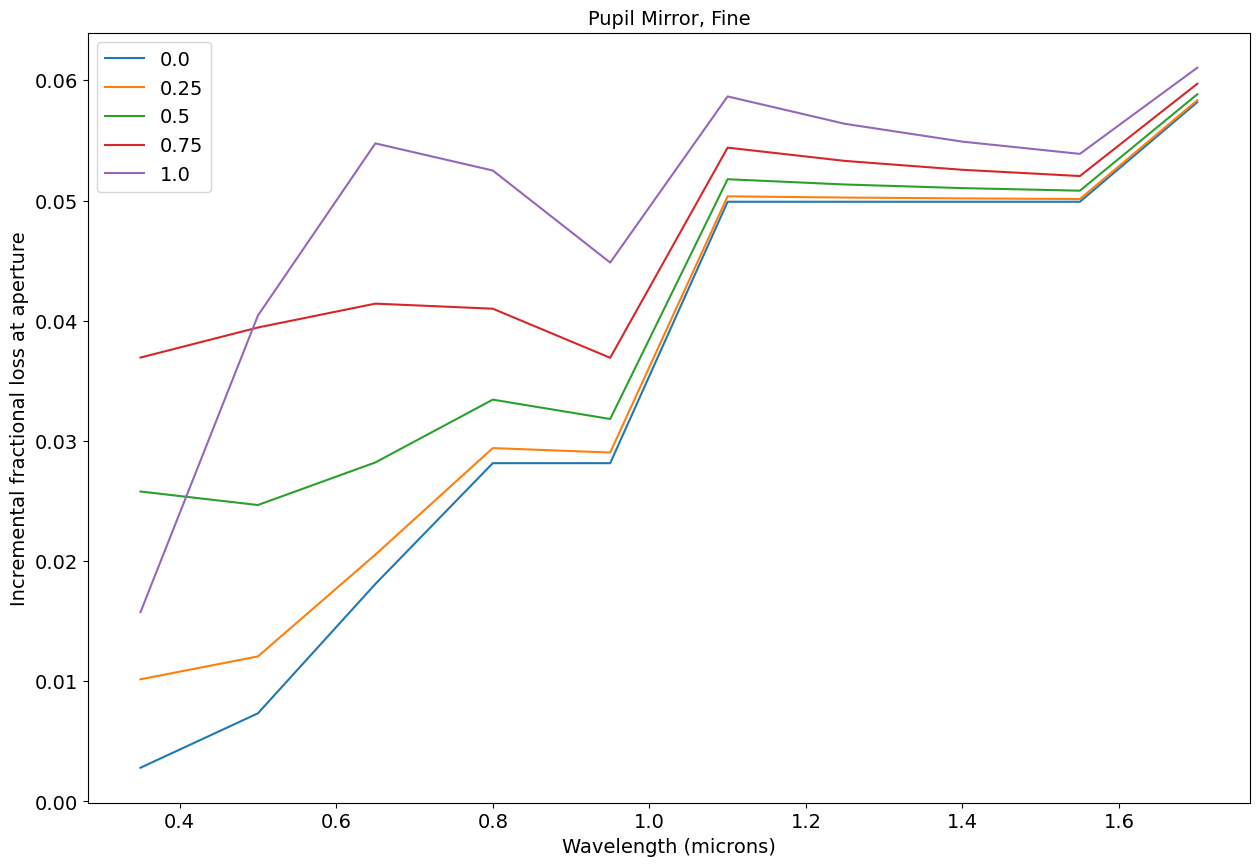

In [8]:
fsize=14
plt.figure(figsize=(15,10))
for j_tilt in range(n_tilt):
    plt.plot(lam_list, frac_pupil_fine[:,j_tilt], label=tilt_list_rel[j_tilt])
plt.legend(fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.xlabel('Wavelength (microns)', fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.ylabel('Incremental fractional loss at aperture', fontsize=fsize)
plt.title('Pupil Mirror, Fine', fontsize=fsize)

Text(0.5, 1.0, 'Pseudoslit Mirror, Fine')

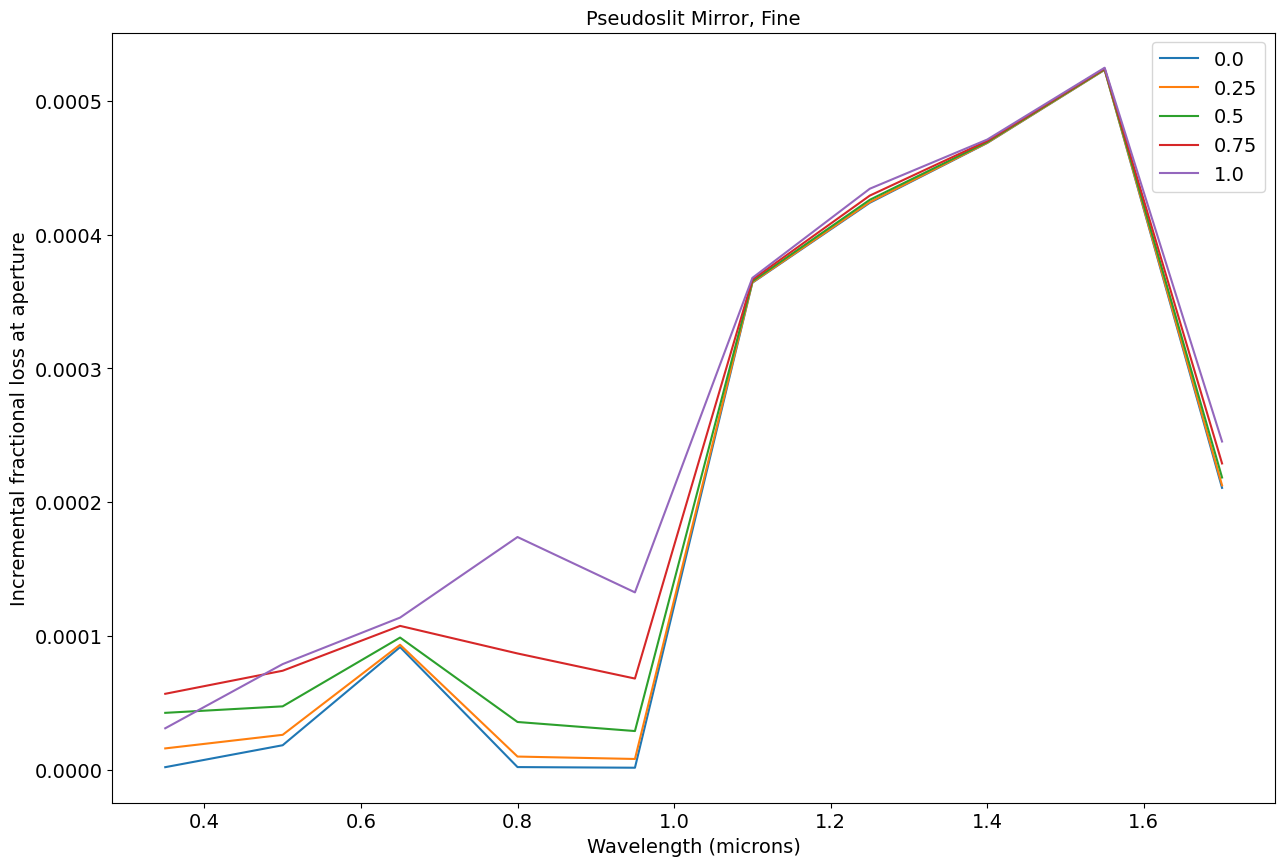

In [9]:
fsize=14
plt.figure(figsize=(15,10))
for j_tilt in range(n_tilt):
    plt.plot(lam_list, frac_pseudo_fine[:,j_tilt], label=tilt_list_rel[j_tilt])
plt.legend(fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.xlabel('Wavelength (microns)', fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.ylabel('Incremental fractional loss at aperture', fontsize=fsize)
plt.title('Pseudoslit Mirror, Fine', fontsize=fsize)

Text(0.5, 1.0, 'Prism Face, Fine')

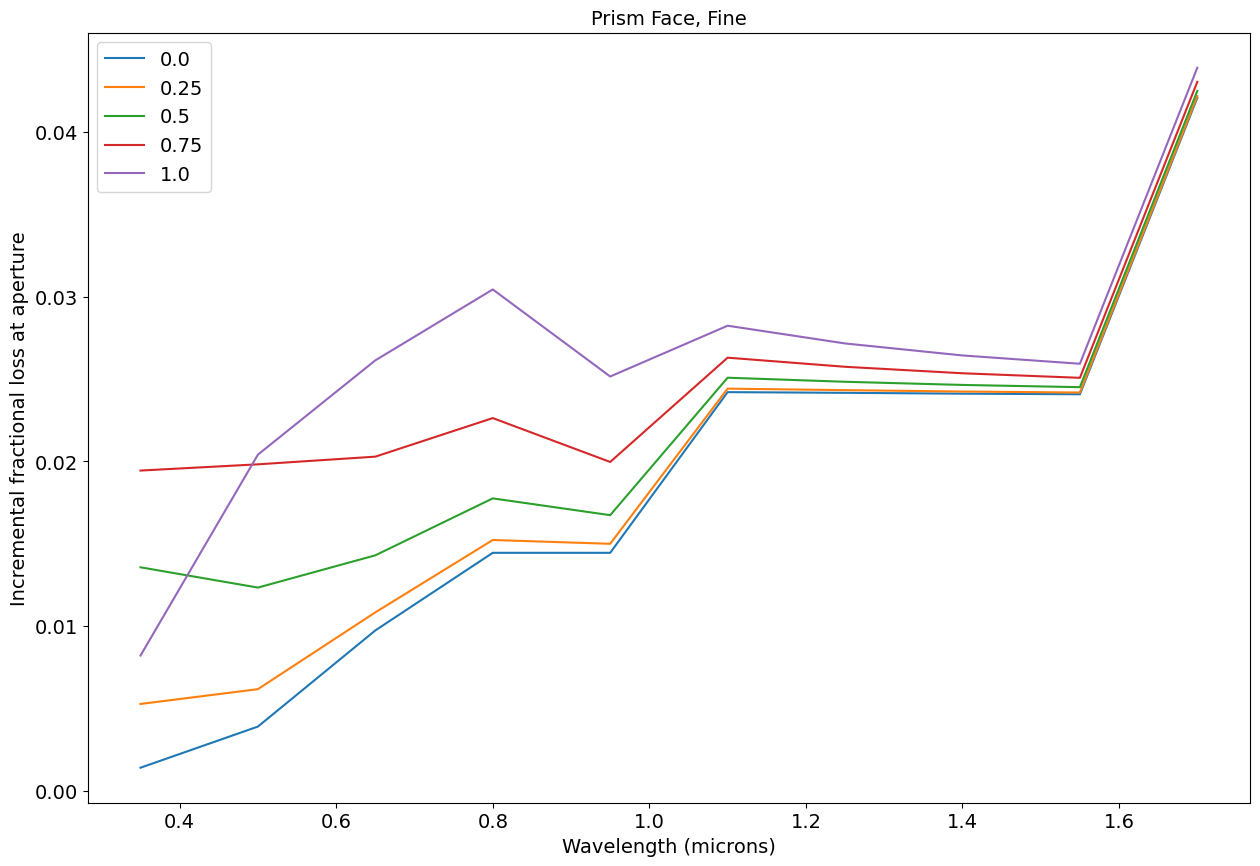

In [10]:
fsize=14
plt.figure(figsize=(15,10))
for j_tilt in range(n_tilt):
    plt.plot(lam_list, frac_spectro_fine[:,j_tilt], label=tilt_list_rel[j_tilt])
plt.legend(fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.xlabel('Wavelength (microns)', fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.ylabel('Incremental fractional loss at aperture', fontsize=fsize)
plt.title('Prism Face, Fine', fontsize=fsize)

Text(0.5, 1.0, 'Pupil Mirror, Coarse')

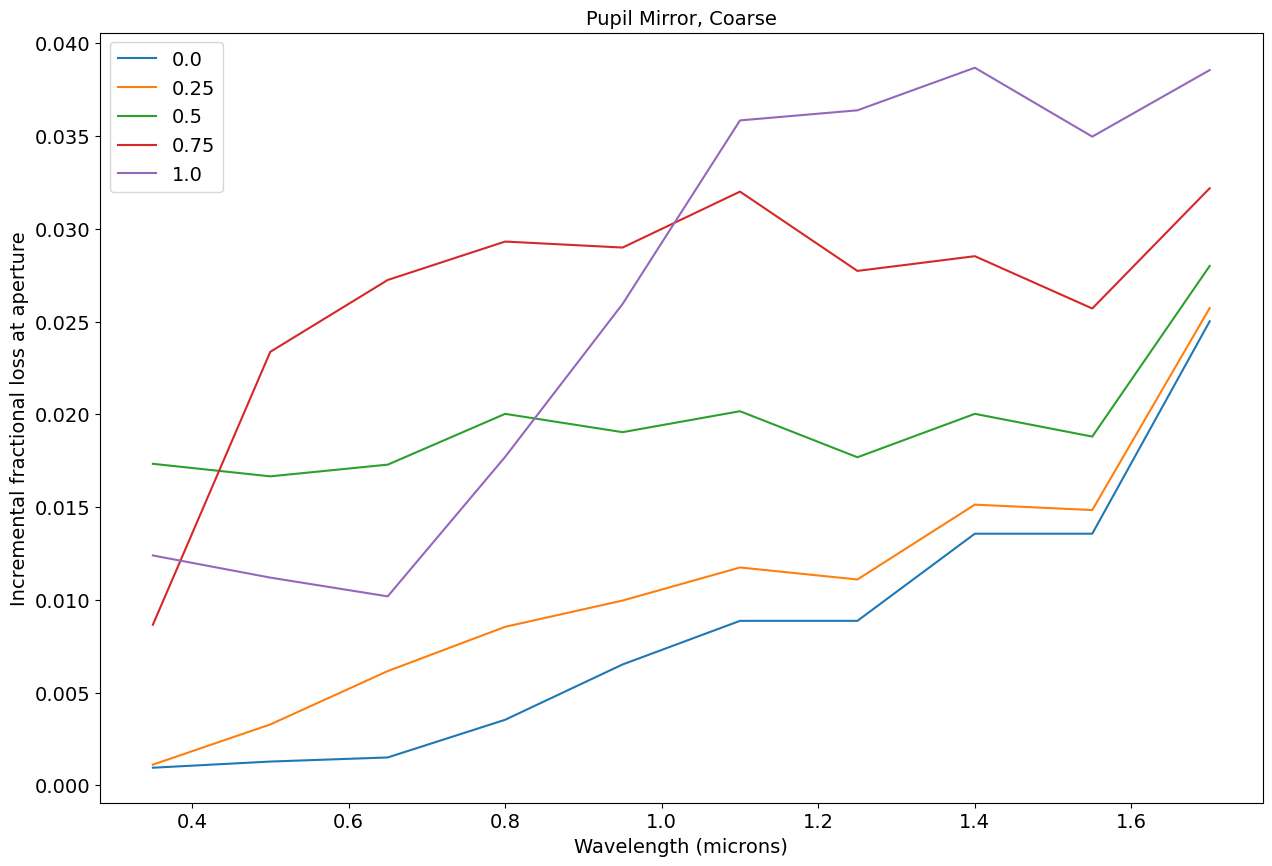

In [11]:
fsize=14
plt.figure(figsize=(15,10))
for j_tilt in range(n_tilt):
    plt.plot(lam_list, frac_pupil_coarse[:,j_tilt], label=tilt_list_rel[j_tilt])
plt.legend(fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.xlabel('Wavelength (microns)', fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.ylabel('Incremental fractional loss at aperture', fontsize=fsize)
plt.title('Pupil Mirror, Coarse', fontsize=fsize)

Text(0.5, 1.0, 'Pseudoslit Mirror, Coarse')

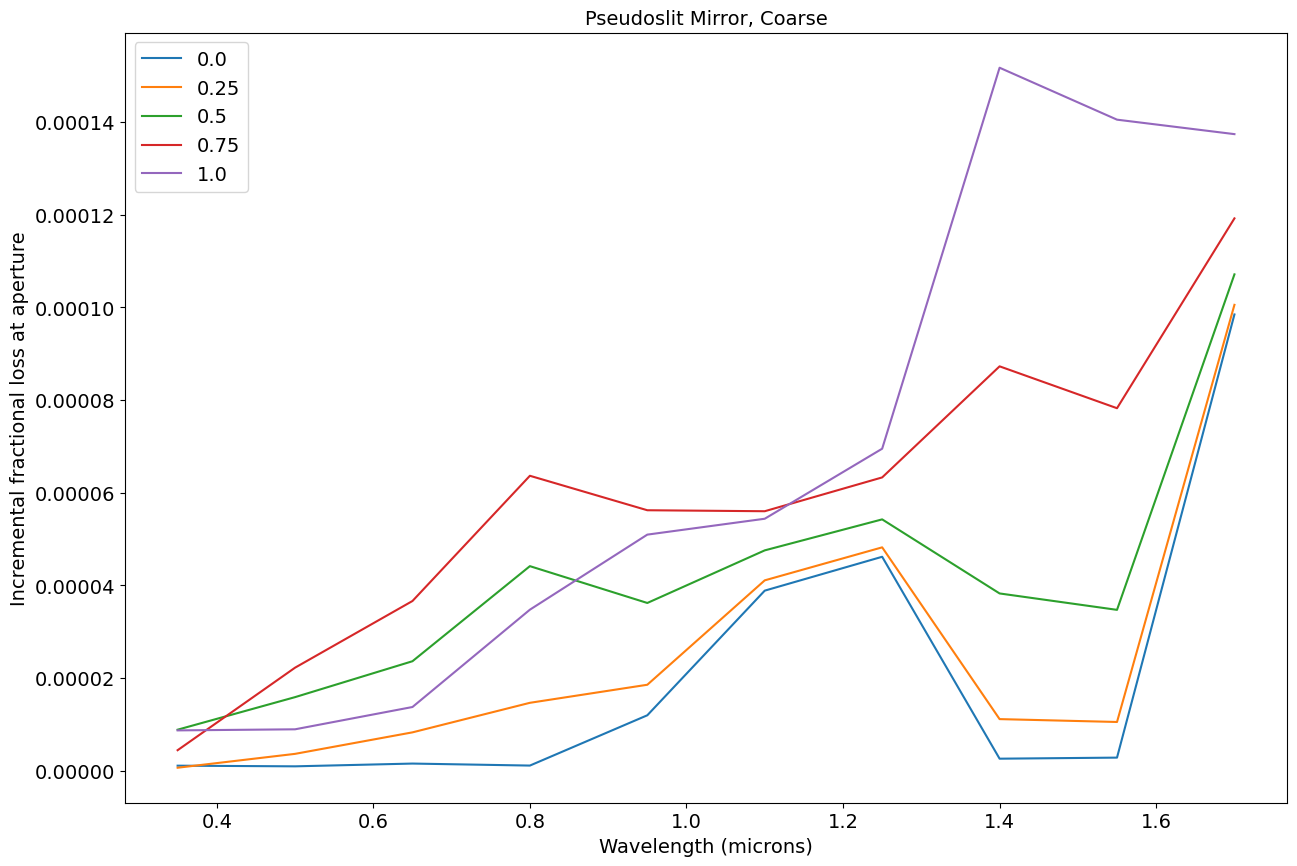

In [12]:
fsize=14
plt.figure(figsize=(15,10))
for j_tilt in range(n_tilt):
    plt.plot(lam_list, frac_pseudo_coarse[:,j_tilt], label=tilt_list_rel[j_tilt])
plt.legend(fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.xlabel('Wavelength (microns)', fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.ylabel('Incremental fractional loss at aperture', fontsize=fsize)
plt.title('Pseudoslit Mirror, Coarse', fontsize=fsize)

Text(0.5, 1.0, 'Prism Face, Coarse')

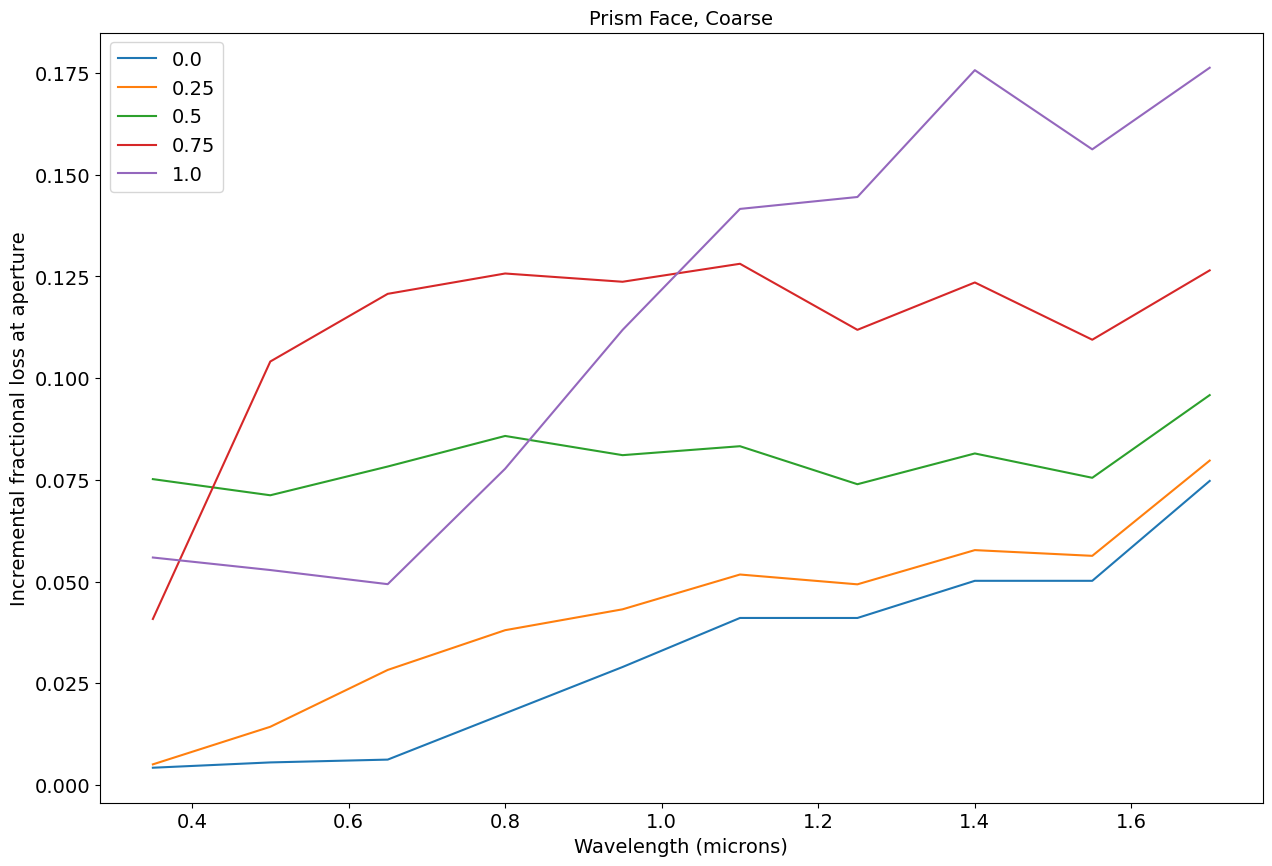

In [13]:
fsize=14
plt.figure(figsize=(15,10))
for j_tilt in range(n_tilt):
    plt.plot(lam_list, frac_spectro_coarse[:,j_tilt], label=tilt_list_rel[j_tilt])
plt.legend(fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.xlabel('Wavelength (microns)', fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.ylabel('Incremental fractional loss at aperture', fontsize=fsize)
plt.title('Prism Face, Coarse', fontsize=fsize)